In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from xgcm import Grid
import glob

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
y = 2010
path = glob.glob('/d1/shared/TXLA_ROMS/output_20yr_obc/%i/ocean_his_00*.nc' % y)
ds = xr.open_mfdataset(path, chunks={'ocean_time':1})

In [5]:
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords)

In [16]:
y = 2010
path = glob.glob('/d1/shared/TXLA_ROMS/output_20yr_obc/%i/ocean_his_00*.nc' % y)
ds = xroms.open_netcdf(path).sel(ocean_time='%i-09' %y)

msk = (ds.lon_rho>-94.5) * (ds.lon_rho<-89.5) * (ds.h>=10.) * (ds.h<=50.)
msk = msk.load()
msk[165:-1, 440:460]= False
msk[130:160, 300:350]= True
msk[76:83, 490:520]= True

In [ ]:
ds.where(msk, drop=True)

In [71]:
dV = ds.dx*ds.dy*ds.dz
do_vm = ((ds.dye_01*dV).where(msk).sum()/dV.where(msk).sum()).compute()

In [72]:
do_vm

<xarray.DataArray ()>
array(169.40583247)

In [18]:
layer = -(ds.z_w.isel(s_w=slice(None,-1)) + ds.h - 10)
imx = (layer.rename({'s_w':'s_rho'}).drop('s_rho')/ds.dz)
imx = imx.where(imx>0, 0).where(imx<1, 1)
imx_u = xroms.to_u(imx, ds.xroms.grid)
imx_v = xroms.to_v(imx, ds.xroms.grid)

In [19]:
qu = (ds.u*ds.dy_u*ds.dz_u*imx_u).sum('s_rho')
qv = (ds.v*ds.dx_v*ds.dz_v*imx_v).sum('s_rho')
nu = ds.xroms.grid.diff(qu, 'X', boundary='extend')
nv = ds.xroms.grid.diff(qv, 'Y', boundary='extend')
w10 = ((nu+nv)/ds.dA)

In [20]:
do_w = xroms.to_s_w(ds.dye_01, ds.xroms.grid)
do10 = xroms.xisoslice(ds.z_w + ds.h, 10., do_w, 's_w')

In [41]:
w10.to_netcdf('w10_sep.nc')
do10.to_netcdf('do10_sep.nc')

In [55]:
w10 = xr.open_dataarray('w10_sep.nc').where(msk, drop=True)
do10 = xr.open_dataarray('do10_sep.nc').where(msk, drop=True)

In [56]:
mean_do = do10.mean().compute()
mean_do

<xarray.DataArray ()>
array(174.31134175)

In [63]:
wob = (w10*do10).mean('ocean_time')
wb = w10.mean('ocean_time')
dob = do10.mean('ocean_time')
wp = w10 - wb
op = do10 - dob
wpop = wp*op
wbob = wb*dob
wpopb = (wp*op).mean('ocean_time')
wo = w10*do10

In [64]:
print(wob[60, 50].values, wbob[60, 50].values, wpopb[60, 50].values)

-0.0017157178160134086 -0.0026763009666076272 0.0009605831505942262


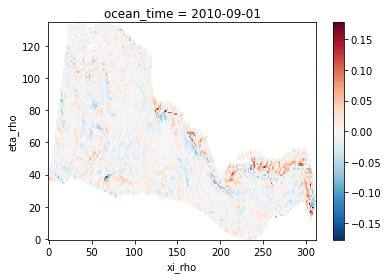

In [58]:
wo.isel(ocean_time=0).plot()

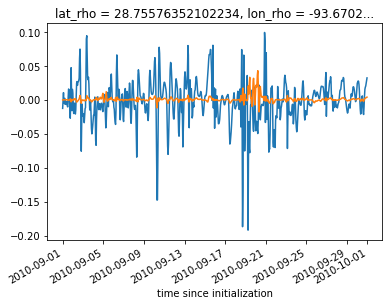

In [62]:
wo[:, 60, 50].plot()
wpop[:, 60, 50].plot()

In [65]:
do_norm = (do10 - mean_do)
wob = (w10*do_norm).mean('ocean_time')
wb = w10.mean('ocean_time')
dob = do_norm.mean('ocean_time')
wp = w10 - wb
op = do_norm - dob
wpop = wp*op
wbob = wb*dob
wpopb = (wp*op).mean('ocean_time')
wo = w10*do_norm

In [66]:
print(wob[60, 50].values, wbob[60, 50].values, wpopb[60, 50].values)

0.0008806731045673788 -7.991004602684745e-05 0.0009605831505942259


In [73]:
do_norm = (do10 - do_vm)
wob = (w10*do_norm).mean('ocean_time')
wb = w10.mean('ocean_time')
dob = do_norm.mean('ocean_time')
wp = w10 - wb
op = do_norm - dob
wpop = wp*op
wbob = wb*dob
wpopb = (wp*op).mean('ocean_time')
wo = w10*do_norm

In [74]:
print(wob[60, 50].values, wbob[60, 50].values, wpopb[60, 50].values)

0.0008076048829600923 -0.0001529782676341328 0.0009605831505942259


In [75]:
print(wob.mean().values, wbob.mean().values, wpopb.mean().values)

0.00040638845895498354 0.000175260996851283 0.00023138374901508966


In [17]:
# etas = [slice(70, 140), slice(71, 141), slice(79, 133), slice(98, 114), slice(104, 109), slice(106, 108)]
# xis = [slice(264, 376), slice(290, 346), slice(300, 337), slice(313, 326), slice(318, 322), 320]

In [76]:
do_norm = (do10.mean(dim=['eta_rho', 'xi_rho']) - do_vm)
w = w10.mean(dim=['eta_rho', 'xi_rho'])
wob = (w*do_norm).mean('ocean_time')
wb = w.mean('ocean_time')
dob = do_norm.mean('ocean_time')
wp = w - wb
op = do_norm - dob
wpop = wp*op
wbob = wb*dob
wpopb = (wp*op).mean('ocean_time')
wo = w*do_norm

In [77]:
print(wob.mean().values, wbob.mean().values, wpopb.mean().values)

1.760223269905343e-05 1.727863407432097e-05 3.2359862473245935e-07


In [23]:
wo = xr.open_dataarray('wo_10_sep.nc')

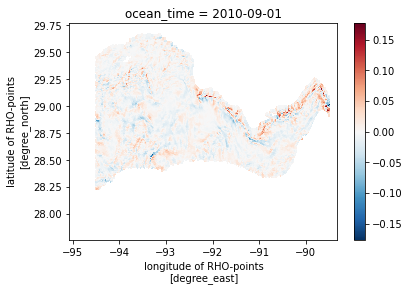

In [40]:
wo.where(msk, drop=True).isel(ocean_time=0).plot(x='lon_rho', y='lat_rho')

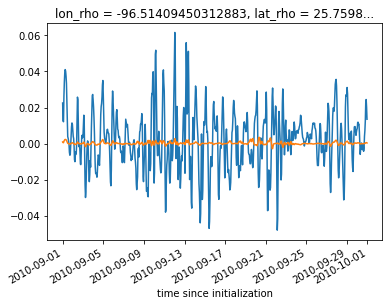

In [25]:
wo[:,60,100].plot()
(wp*op)[:,60,100].plot()

array(1.07859511e-05)

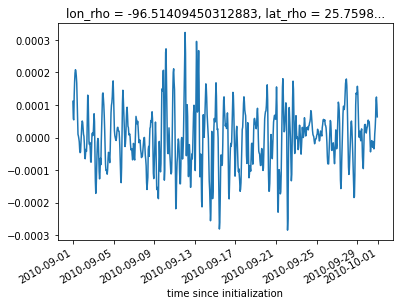

In [31]:
wp[:,60,100].plot()
w10[:,60,100].mean().values

array(176.37850813)

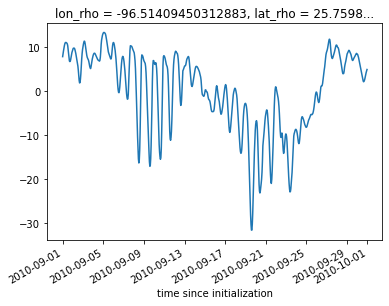

In [32]:
op[:,60,100].plot()
do10[:,60,100].mean().values

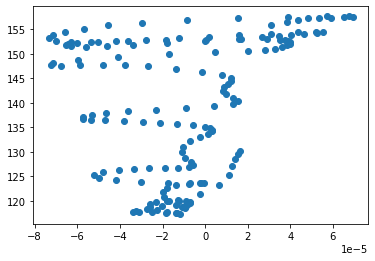

In [38]:
plt.scatter(w10[:24*7,60:70,100:110].mean(dim=['eta_rho', 'xi_rho']).values,
            do10[:24*7,60:70,100:110].mean(dim=['eta_rho', 'xi_rho']).values)

In [9]:
# wo.where(msk, drop=True).to_netcdf('wo_10.nc')
# do10.where(msk, drop=True).to_netcdf('do_10.nc')
# w10.where(msk, drop=True).to_netcdf('w_10.nc')

In [16]:
wo_m = wo.mean('ocean_time')
do10_m = do10.mean('ocean_time')
w10_m = w10.mean('ocean_time')

wp = w10 - w10_m
op = do10 - do10_m

wbob = w10_m * do10_m
wpopb = (wp*op).mean('ocean_time')

In [17]:
# wbob.where(msk, drop=True).to_netcdf('wbob_sep.nc')

In [11]:
# wp.to_netcdf('wp_10_sep.nc')
# op.to_netcdf('op_10_sep.nc')

In [12]:
# wo_m.where(msk, drop=True).to_netcdf('wo_m_sep.nc')
# do10_m.where(msk, drop=True).to_netcdf('do10_m.nc')
# w10_m.where(msk, drop=True).to_netcdf('w10_m.nc')

In [11]:
# # wbob.where(msk, drop=True).to_netcdf('wbob.nc')
wp = xr.open_dataarray('wp_10_sep.nc')
op = xr.open_dataarray('op_10_sep.nc')
wpopb = (wp*op).mean('ocean_time').where(msk, drop=True)

In [20]:
wpopb.to_netcdf('wpopb_sep.nc')

In [21]:
wo_m = xr.open_dataarray('wo_m_sep.nc')
wbob = xr.open_dataarray('wbob_sep.nc')
wpopb = xr.open_dataarray('wpopb_sep.nc')

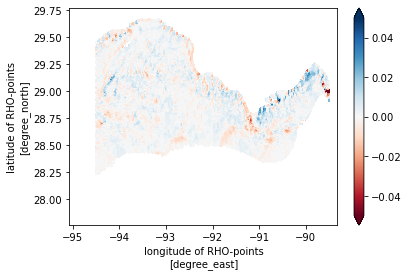

In [8]:
wo_m.plot(x='lon_rho', y='lat_rho', vmin=-.5e-1, vmax=.5e-1, cmap='RdBu')

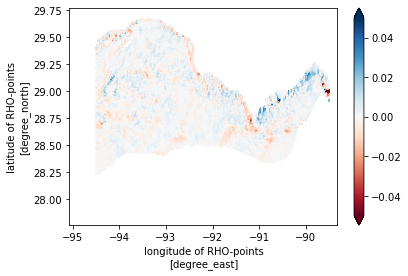

In [22]:
wbob.plot(x='lon_rho', y='lat_rho', vmin=-.5e-1, vmax=.5e-1, cmap='RdBu')

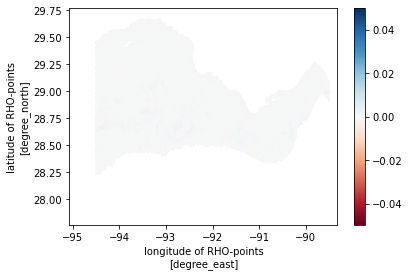

In [23]:
wpopb.plot(x='lon_rho', y='lat_rho', vmin=-.5e-1, vmax=.5e-1, cmap='RdBu')

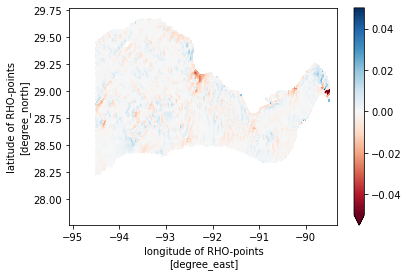

In [18]:
wo_m.plot(x='lon_rho', y='lat_rho', vmin=-.5e-1, vmax=.5e-1, cmap='RdBu')

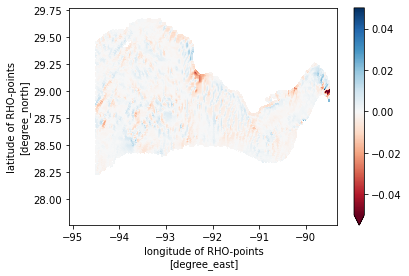

In [19]:
wbob.plot(x='lon_rho', y='lat_rho', vmin=-.5e-1, vmax=.5e-1, cmap='RdBu')

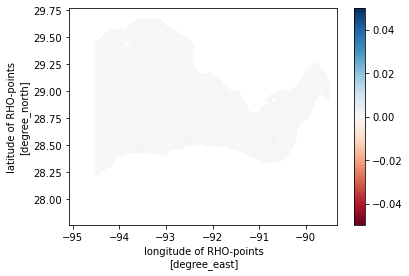

In [20]:
wpopb.plot(x='lon_rho', y='lat_rho', vmin=-.5e-1, vmax=.5e-1, cmap='RdBu')

In [23]:
ou = ds.xroms.to_grid('dye_01', hcoord='u')*ds.u*ds.dy_u*ds.dz_u*imx_u
ov = ds.xroms.to_grid('dye_01', hcoord='v')*ds.v*ds.dx_v*ds.dz_v*imx_v

In [46]:
oadv = ou.isel(eta_rho= etas[n], xi_u=xis[n].start-1).sum(dim=['s_rho', 'eta_rho']) + \
        ou.isel(eta_rho= etas[n], xi_u=xis[n].stop-1).sum(dim=['s_rho', 'eta_rho']) + \
        ov.isel(eta_v= etas[n].start-1, xi_rho= xis[n]).sum(dim=['s_rho', 'xi_rho']) +\
        ov.isel(eta_v= etas[n].stop-1, xi_rho= xis[n]).sum(dim=['s_rho', 'xi_rho'])

In [48]:
oadv.to_netcdf('hoadv.nc')

In [49]:
def get_SOD(ds):
    btm_ox = ds.dye_01.isel(s_rho=0)
    btm_tmp = ds.temp.isel(s_rho=0)
    SOD = 6. * 2.**(.1 * btm_tmp) * (1. - np.exp(- .033 * btm_ox)) / 86400.
    return SOD

In [50]:
sod = (get_SOD(ds)*ds.dA).isel(eta_rho=etas[n], xi_rho=xis[n]).sum(dim=['eta_rho', 'xi_rho'])

In [52]:
sod.to_netcdf('sod.nc')

In [56]:
mdo = (ds.dye_01*ds.dx*ds.dy*ds.dz*i_mx).isel(eta_rho=etas[n], xi_rho=xis[n]).sum(dim=['s_rho','eta_rho', 'xi_rho'])

In [59]:
(mdo.diff('ocean_time')/3600).to_netcdf('rate.nc')

In [60]:
n = 0
qu = (ds.u*ds.dy_u*ds.dz_u*imx_u).isel(eta_rho= etas[n]).sum(dim=['s_rho', 'eta_rho'])
qv = (ds.v*ds.dx_v*ds.dz_v*imx_v).isel(xi_rho= xis[n]).sum(dim=['s_rho', 'xi_rho'])
ul = qu.isel(xi_u=xis[n].start-1)
ur = qu.isel(xi_u=xis[n].stop-1)
vb = qv.isel(eta_v= etas[n].start-1)
vt = qv.isel(eta_v= etas[n].stop-1)
w = (ul+ur+vb+vt)/ds.dA.isel(eta_rho=etas[n], xi_rho=xis[n]).sum()

In [62]:
w.to_netcdf('w2_ts.nc')

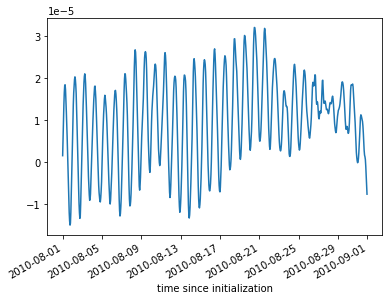

In [44]:
# w= xr.open_dataarray('w_ts.nc')
(w/(ds.dA).isel(eta_rho=etas[n], xi_rho=xis[n]).sum()).plot()

In [30]:
n = 0
print(xis[n].start-1)
print(xis[n].stop-1)

263
375


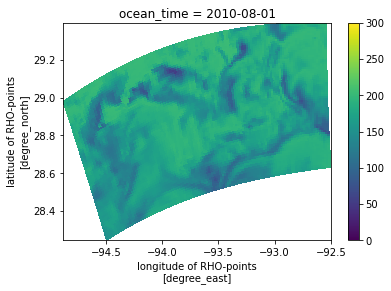

In [80]:
do10.isel(ocean_time=0, eta_rho=etas[n], xi_rho=xis[n]).plot(x='lon_rho', y='lat_rho', vmin=0, vmax=300)

In [81]:
mo = (do10*ds.dA).isel(eta_rho=etas[n], xi_rho=xis[n]).sum(dim=['eta_rho', 'xi_rho'])/ds.dA.isel(eta_rho=etas[n], xi_rho=xis[n]).sum(dim=['eta_rho', 'xi_rho'])

In [83]:
mo.to_netcdf('do10_ts.nc')

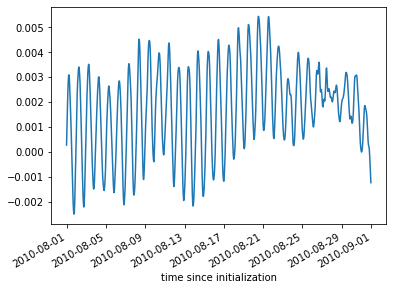

In [86]:
(w*mo).plot()

In [87]:
bg_ts = xr.open_dataset('files/mean_xl_ts.nc')

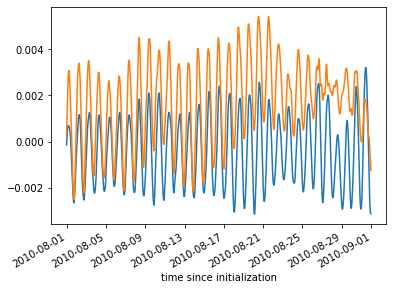

In [91]:
bg_ts.vadv.sel(ocean_time='2010-08').plot()
(w*mo).plot()

In [96]:
wo_b = bg_ts.vadv.sel(ocean_time='2010-08').mean().compute()
w_b = w.mean().compute()
o_b = mo.mean().compute()

In [97]:
print(wo_b.values, (w_b*o_b).values)

-0.0003631683104751099 0.0016650571662183739


In [ ]:
<wo>, <w><o>